# Bodily signals & MEG

In [1]:
import mne
from mne.preprocessing import ICA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

We will open a resting state MEG data set which includes ECG and breathing-belt signal.

In [2]:
datapath = "/Users/b1019548/Library/CloudStorage/OneDrive-UniversitätSalzburg/Teaching/Master_VO_MethodsCogNeuro/Lecture7_Interoception/data/20010321anae_rest_trans_sss.fif"

#ECG: ECG003; Breathing: MISC001
raw = mne.io.read_raw_fif(datapath, preload=True)

Opening raw data file /Users/b1019548/Library/CloudStorage/OneDrive-UniversitätSalzburg/Teaching/Master_VO_MethodsCogNeuro/Lecture7_Interoception/data/20010321anae_rest_trans_sss.fif...


/var/folders/hq/25wkh5ks4x3bl8rfsmsnt_vw2w8qk_/T/ipykernel_89087/2991254400.py:4: RuntimeWarning: This filename (/Users/b1019548/Library/CloudStorage/OneDrive-UniversitätSalzburg/Teaching/Master_VO_MethodsCogNeuro/Lecture7_Interoception/data/20010321anae_rest_trans_sss.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(datapath, preload=True)


    Range : 10000 ... 311999 =     10.000 ...   311.999 secs
Ready.
Reading 0 ... 301999  =      0.000 ...   301.999 secs...


First perform a spectral analysis on the ECG and breathing belt signal. We will normalize the spectra by the max-power so that they are on same scale.

Effective window size : 2.048 (s)
Effective window size : 2.048 (s)
Peak Freqeuency Breathing:  0.48828125 Hz
Peak Freqeuency Breathing:  0.9765625 Hz


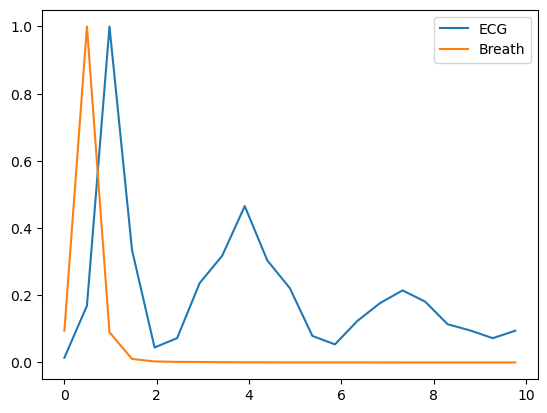

In [3]:
#Spectrum ECG, breathing
psd_ecg = raw.copy().compute_psd(picks="ecg", fmin = 0, fmax = 10)
psd_breath = raw.copy().compute_psd(picks="misc", fmin = 0, fmax = 10)

plt.plot(psd_ecg.freqs, np.transpose(psd_ecg._data)/np.max(psd_ecg._data))
plt.plot(psd_ecg.freqs, np.transpose(psd_breath._data)/np.max(psd_breath._data))
plt.legend(['ECG', 'Breath'])

print("Peak Freqeuency Breathing: ", psd_breath.freqs[np.argmax(psd_breath._data)], "Hz")
print("Peak Freqeuency Breathing: ", psd_ecg.freqs[np.argmax(psd_ecg._data)], "Hz")

The resporation data is slow. Let's mess around and see whether heart rate is influenced by respiratory phase.

In a first step we will low-pass filter the respiration data and calculate the instantaneous phase.

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 1.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 1651 samples (1.651 s)



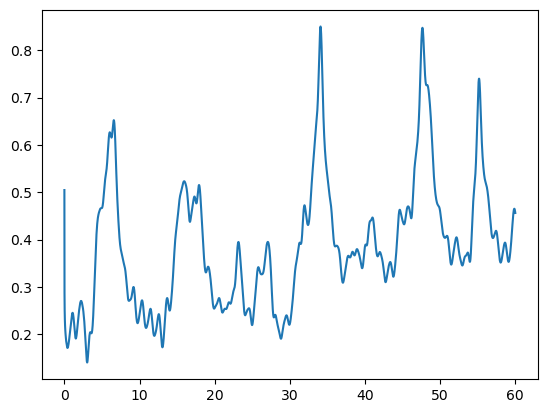

In [4]:
#low_breath_raw = raw.copy().pick(picks="misc").filter(l_freq = None, h_freq = 1).apply_hilbert()
low_breath_raw = raw.copy().pick("misc")
low_breath_raw.filter(picks='all', l_freq=None, h_freq=1).apply_hilbert(picks='all');

low_breath_angle = np.angle(low_breath_raw.get_data())

durpoints = int(60 * low_breath_raw.info['sfreq'])
plt.plot(low_breath_raw.times[:durpoints], np.abs(low_breath_raw.get_data()[0,:durpoints])) #plot envelope

Now, we take the ECG and detect the R-wave peaks.

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Filter length: 1651 samples (1.651 s)



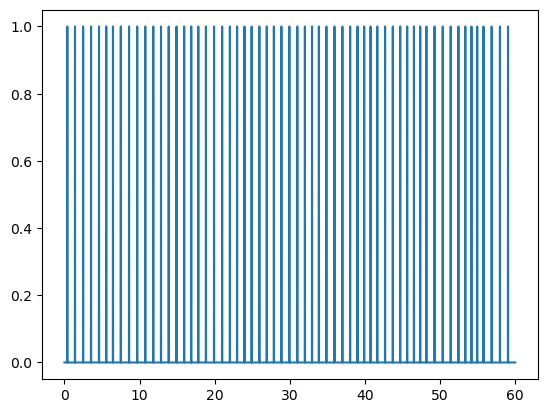

In [5]:
ecg_raw = raw.copy().pick("ecg")
ecg_raw.filter(picks='all', l_freq=2, h_freq=None)

ecg_data = np.abs(ecg_raw.get_data())
ecg_thresh = ecg_data > 0.0015 #visual inspection threshols

#plt.plot(ecg_raw.times[:durpoints], ecg_raw.get_data()[0,:durpoints]) #plot envelope
plt.plot(ecg_raw.times[:durpoints], ecg_thresh[0,:durpoints]) #plot envelope

We will test whether heart beats cluster in the cyclce of respiration.

Here a small function to bin the angles of the respiration data and compute the probability of a heartbeat.

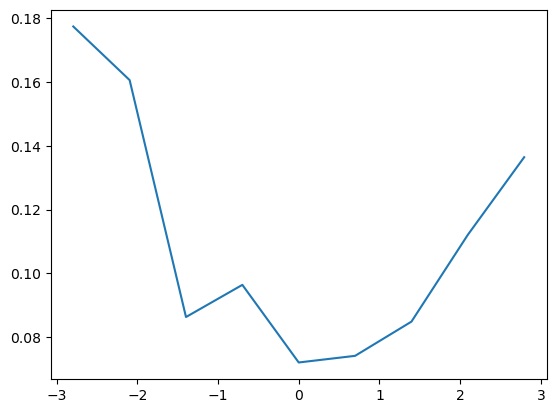

In [13]:
def bin_and_prob(low_breath_angle, ecg_thresh, num_bins=10):
    """
    Bins low_breath_angle into num_bins and calculates the probability of 1s in ecg_thresh within each bin
    """
    bin_edges = np.linspace(-np.pi, np.pi, num_bins+1)
    bin_probs = []
    for i in range(num_bins):
        bin_ecg = ecg_thresh[(low_breath_angle >= bin_edges[i]) & (low_breath_angle < bin_edges[i+1])]
        bin_probs.append(np.sum(bin_ecg)/np.sum(ecg_thresh))
    
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return bin_centers, bin_probs

bin_centers, bin_probs = bin_and_prob(low_breath_angle, ecg_thresh, num_bins=9)
plt.plot(bin_centers, bin_probs)

# Heartbeat evoked response (HER)

Now let's calculate HER. We will epoch the resting state data sets, using the automatic routine from MNE to detect heartbeats.

Using channel ECG003 to identify heart beats.
Setting up low-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal lowpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window


- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 20.25 Hz)
- Filter length: 10000 samples (10.000 s)

Number of ECG events detected : 309 (average pulse 61 / min.)
Not setting metadata
309 matching events found
No baseline correction applied
Using data from preloaded Raw for 309 events and 701 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


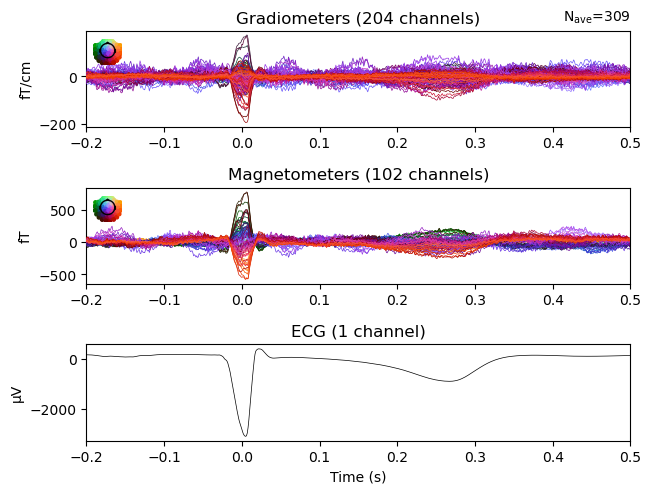

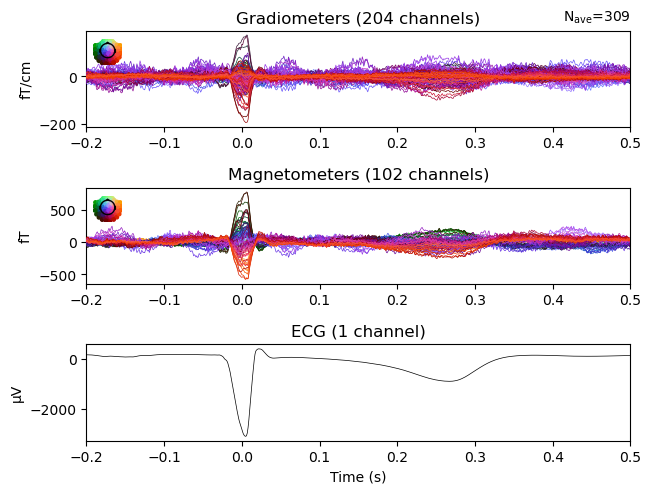

In [24]:
ecg_epochs = mne.preprocessing.create_ecg_epochs(raw, tmin = -.2, tmax = .5, l_freq = None, h_freq = 20)
HER = ecg_epochs.average(picks = ['meg', 'ecg'])
HER.plot(picks = ['all']);

Averaging shows an enormous response on the MEG!

But is it really brain data? Topographies show an enormous instantaneous effect. That is always an indicator of artefact (volume conduction).

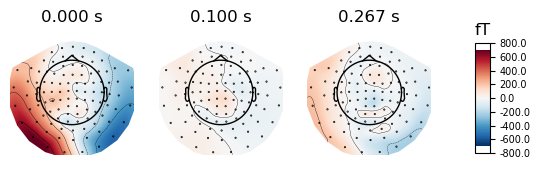

In [29]:
HER.plot_topomap(times=[0, .1, .267]);

# Reducing volume conduction influence

To reduce the effect of volume vonduction [Independent Component Analysis](https://mne.tools/dev/auto_tutorials/preprocessing/40_artifact_correction_ica.html) (ICA) is a very popular approach.

In [31]:
ica = ICA(n_components=50, max_iter="auto", random_state=97) #makes the output reproducible
ica.fit(ecg_epochs)

Fitting ICA to data using 306 channels (please be patient, this may take a while)
Selecting by number: 50 components
Fitting ICA took 75.4s.


Method,fastica
Fit,192 iterations on epochs (216609 samples)
ICA components,50
Available PCA components,306
Channel types,"mag, grad"
ICA components marked for exclusion,—


Plotting topographies and time series give good feeling which ones are artifact related (also automatic routines).

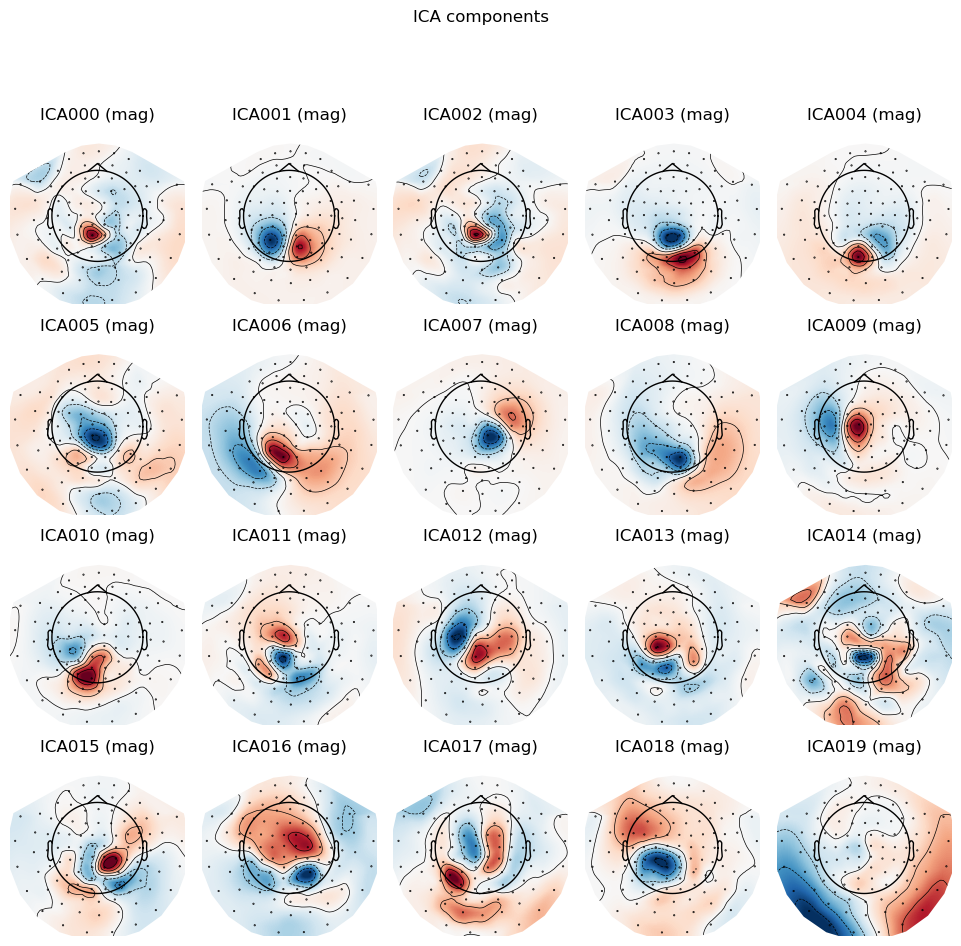

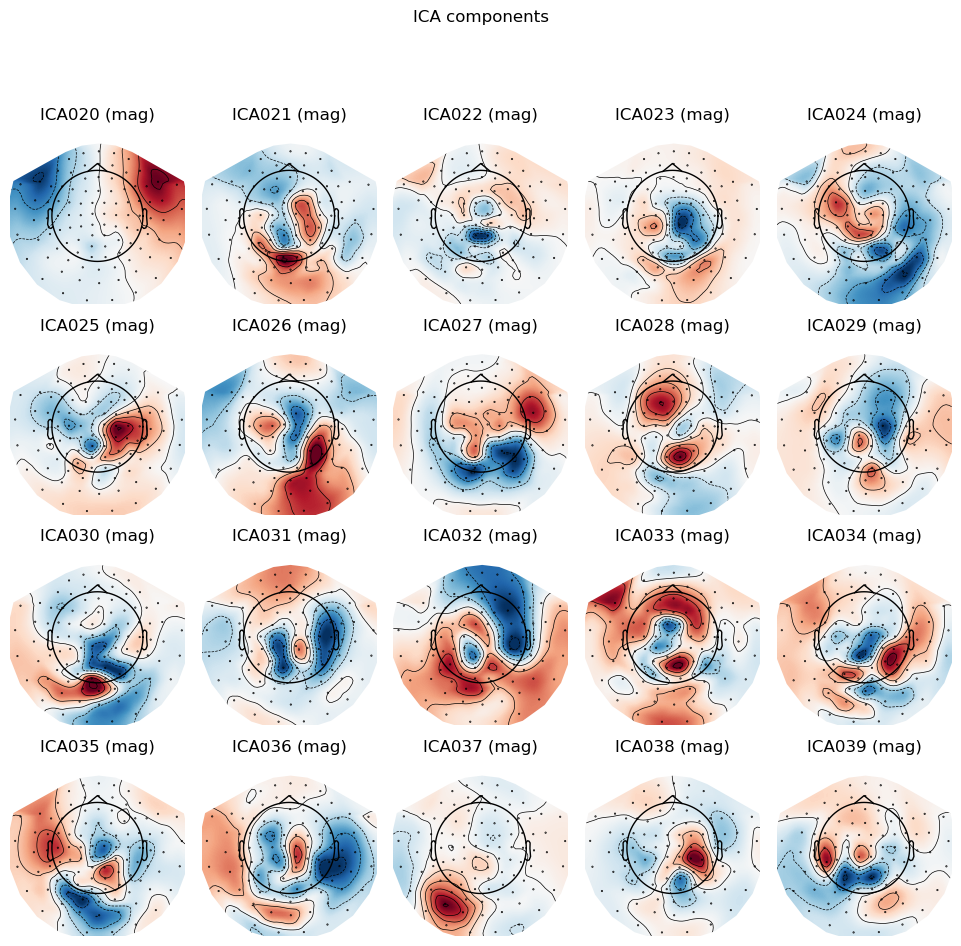

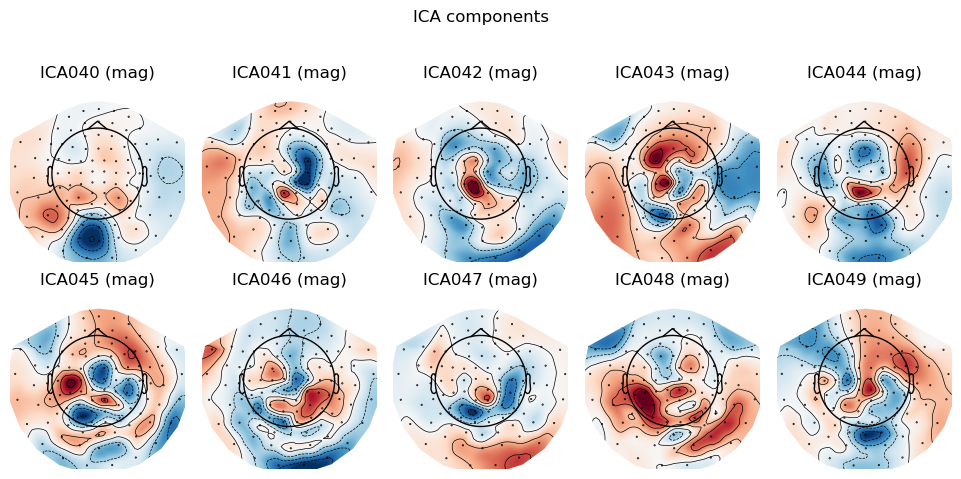

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x496 with 10 Axes>]

In [32]:
ica.plot_components()

Exercise: can you spot ocular activity?

We now can remove the most prominent cardiac artifact and reconstruct the epochs without the influence.

In [33]:
ica.exclude = [19]

ecg_epochs_ica = ecg_epochs.copy()
ica.apply(ecg_epochs_ica)

Applying ICA to Epochs instance
    Transforming to ICA space (50 components)
    Zeroing out 1 ICA component
    Projecting back using 306 PCA components


Number of events,309
Events,999: 309
Time range,-0.200 – 0.500 s
Baseline,off


Let's rerun the HER analysis.

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


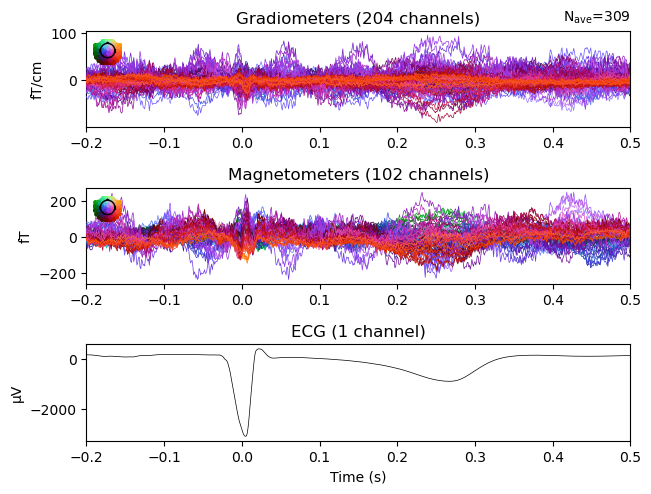

In [36]:
HER_ica = ecg_epochs_ica.average(picks = ['meg', 'ecg'])
HER_ica.plot();

We can compare the topographies with and without ICA correction.

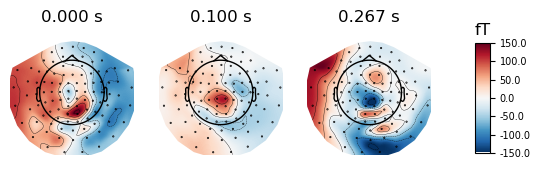

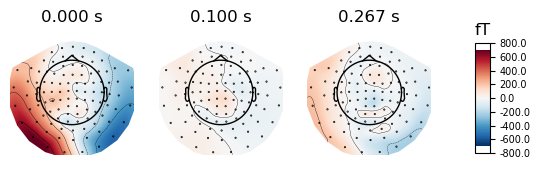

In [40]:
HER_ica.plot_topomap(times=[0, .1, .267])
HER.plot_topomap(times=[0, .1, .267]);

In [55]:
#PLOT GFPs

HER_RMS= np.sqrt(np.mean(np.square(HER.get_data()[1:]), axis = 0))
HER_RMS_ica= np.sqrt(np.mean(np.square(HER_ica.get_data()[1:]), axis = 0))

Let's use the Root-Mean-Square across all sensors to compare how well ICA removes cardiac activity.

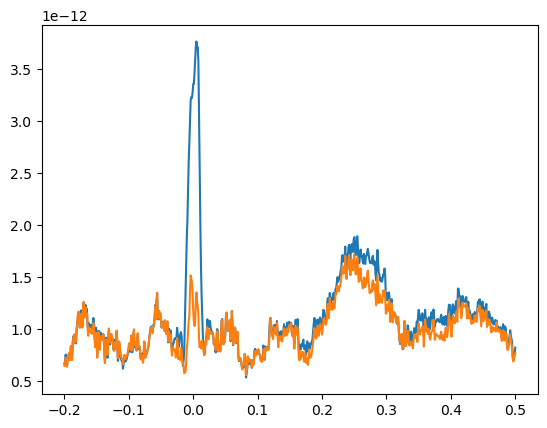

In [56]:
plt.plot(HER.times, HER_RMS)
plt.plot(HER.times, HER_RMS_ica)